# Analysis of Scenario-Level Ensemble Scores

**Objective:** To load and analyze the aggregated scenario difficulty scores
generated by `score_criticality_ensemble_scenario.py`. This notebook helps us understand
the overall distribution of "scenario confusion" and provides tools to visually
inspect the most confusing scenarios to validate our model-based scoring logic.

In [1]:
# ## 1. Setup and Configuration

# +
import os
import sys
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Add project root to path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.config import load_config
from src.data_processing.validate_parser_output import visualize_scenario

# Load project config and set plot style
config = load_config(config_path='../configs/main_config.yaml')
sns.set_theme(style="whitegrid")

print("Setup Complete.")

Configuration loaded successfully.
Setup Complete.


Loaded scores for 106487 scenarios.

--- Overall Score Statistics (P99 of Disagreement) ---
count    106487.000000
mean          0.854256
std           0.375795
min           0.022191
25%           0.584792
50%           0.852929
75%           1.091900
max           5.404664
Name: score, dtype: float64


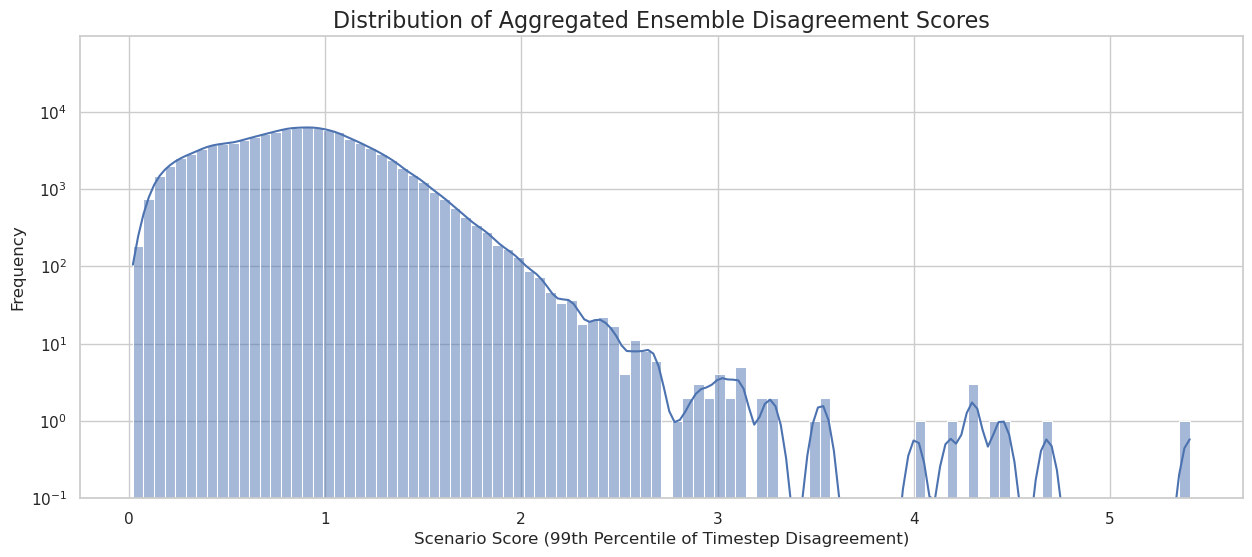


--- Top 10 Most Confusing Scenarios (Highest Peak Disagreement) ---


,scenario_id,score,normalized_score
8278,2434370bacb06bd2,5.404664,1.000000
46440,8237ff42ca51232e,4.678049,0.865558
35369,6707ddbe67f0354,4.464328,0.826014
53622,93bbb2dfde328786,4.427211,0.819146
22619,478ded87942dea82,4.299640,0.795542
52091,8fefb9afc4d0f9ce,4.299640,0.795542
67685,b63d9564d18cec14,4.299640,0.795542
52330,908ba3d8c9dc0cf4,4.180834,0.773560
58436,9f631a9e835d21df,4.007992,0.741580
87677,e74e1f862ffb2f2a,3.536514,0.654345


In [9]:
# ## 2. Load Scenario Scores and Analyze Distribution
# 
# Load the final `.pt` file containing the dictionary of `{scenario_id: score}` and analyze its global properties.

# +
# --- Load the Data ---
scores_dir = os.path.join(config['data']['criticality_scores_dir'], 'scenario_level')
ensemble_scores_path = os.path.join(scores_dir, 'ensemble_scenario_scores.pt')

if not os.path.exists(ensemble_scores_path):
    raise FileNotFoundError("Ensemble scenario scores not found. "
                            "Please run `score_criticality_ensemble_scenario.py` first.")

scenario_scores_dict = torch.load(ensemble_scores_path)

# Convert to a Pandas DataFrame for easy analysis and sorting
scores_df = pd.DataFrame(list(scenario_scores_dict.items()), columns=['scenario_id', 'score'])
# Normalize the score to a 0-1 range for easier interpretation
if scores_df['score'].max() > 0:
    scores_df['normalized_score'] = scores_df['score'] / scores_df['score'].max()
else:
    scores_df['normalized_score'] = 0.0


print(f"Loaded scores for {len(scores_df)} scenarios.")

# --- Analyze and Plot Distribution ---
print("\n--- Overall Score Statistics (P99 of Disagreement) ---")
print(scores_df['score'].describe())

plt.figure(figsize=(15, 6))
sns.histplot(scores_df['score'], bins=100, kde=True)
plt.title('Distribution of Aggregated Ensemble Disagreement Scores', fontsize=16)
plt.xlabel('Scenario Score (99th Percentile of Timestep Disagreement)')
plt.ylabel('Frequency')
plt.yscale('log') # Use log scale to see the long tail
plt.ylim(bottom=0.1) # Avoid log(0) issues
plt.show()

# --- Identify Top "Confusing" Scenarios ---
top_10_confusing_scenarios = scores_df.sort_values(by='score', ascending=False).head(10)
print("\n--- Top 10 Most Confusing Scenarios (Highest Peak Disagreement) ---")
display(top_10_confusing_scenarios)

--- Deep Dive Analysis for Top Scenario: 478ded87942dea82 ---
Overall Scenario Score (P99 Disagreement): 4.2996


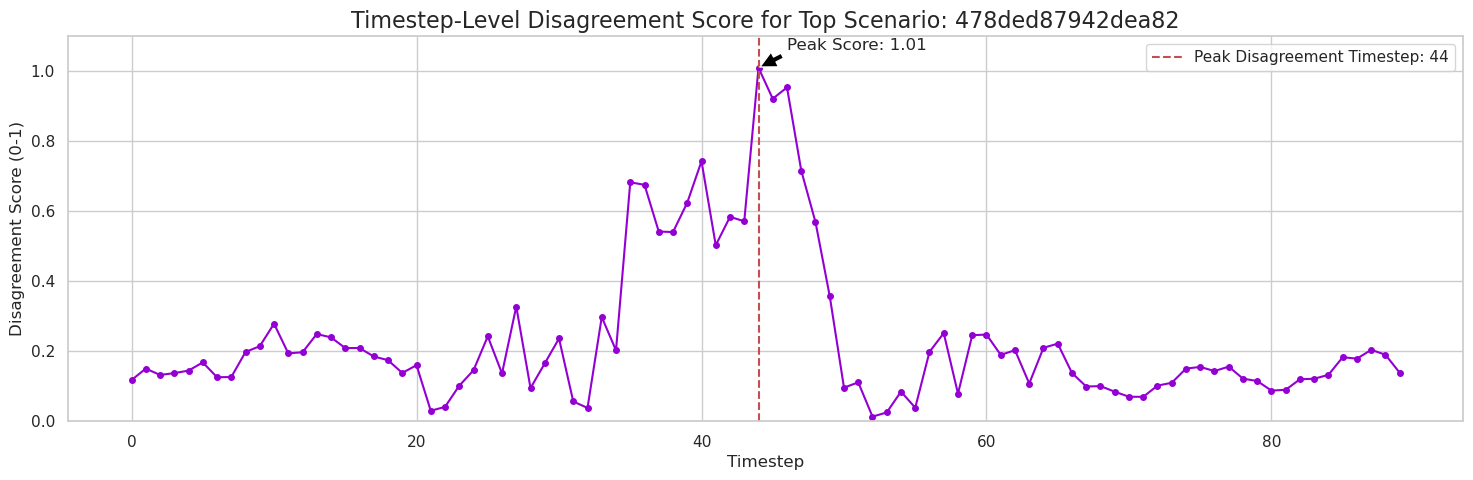

In [18]:
# ## 3. Deep Dive into a Top Confusing Scenario
# 
# Let's pick the #1 most confusing scenario and visualize its underlying timestep-level disagreement scores to understand *why* it received such a high score.

# +
# Select the top scenario
top_scenario_id = top_10_confusing_scenarios.iloc[4]['scenario_id']
top_scenario_score = top_10_confusing_scenarios.iloc[4]['score']

print(f"--- Deep Dive Analysis for Top Scenario: {top_scenario_id} ---")
print(f"Overall Scenario Score (P99 Disagreement): {top_scenario_score:.4f}")

# --- Load its timestep-level score components ---
timestep_scores_path = os.path.join(
    config['data']['criticality_scores_dir'], 
    'timestep_level', 
    'ensemble', 
    'training', # Assuming it's from the training set
    f"{top_scenario_id}.npz"
)

if not os.path.exists(timestep_scores_path):
    # Check validation set if not in training
    timestep_scores_path = os.path.join(
        config['data']['criticality_scores_dir'], 
        'timestep_level', 
        'ensemble', 
        'validation',
        f"{top_scenario_id}.npz"
    )
    if not os.path.exists(timestep_scores_path):
        raise FileNotFoundError(f"Could not find timestep-level ensemble scores for {top_scenario_id}")

scores_data = np.load(timestep_scores_path)
disagreement_scores = scores_data['ensemble']

# --- Plot the underlying score components ---
fig, ax = plt.subplots(figsize=(18, 5))
timesteps = np.arange(len(disagreement_scores))

ax.plot(timesteps, disagreement_scores, marker='o', linestyle='-', markersize=4, color='darkviolet')
ax.set_title(f'Timestep-Level Disagreement Score for Top Scenario: {top_scenario_id}', fontsize=16)
ax.set_xlabel('Timestep')
ax.set_ylabel('Disagreement Score (0-1)')
ax.set_ylim(0, 1.1)
ax.grid(True)

# Highlight the moment of peak disagreement
peak_timestep = np.argmax(disagreement_scores)
peak_score = np.max(disagreement_scores)
ax.axvline(x=peak_timestep, color='r', linestyle='--', label=f'Peak Disagreement Timestep: {peak_timestep}')
ax.annotate(f'Peak Score: {peak_score:.2f}', 
            xy=(peak_timestep, peak_score), 
            xytext=(peak_timestep + 2, peak_score + 0.05),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend()
plt.show()

In [19]:
# ## 4. Generate Video for the Top Confusing Scenario
# 
# Finally, let's watch the video. What happens around the `Peak Disagreement Timestep`? Is it an unprotected left turn? A chaotic intersection? A pedestrian behaving strangely? This visual confirmation is key to trusting our model-based score.

# +
raw_data_path = os.path.join(
    config['data']['processed_npz_dir'], 
    'training', # Assuming it's from the training set
    f"{top_scenario_id}.npz"
)
if not os.path.exists(raw_data_path):
    # Check validation set if not in training
    raw_data_path = os.path.join(
        config['data']['processed_npz_dir'], 
        'validation',
        f"{top_scenario_id}.npz"
    )

print(f"\nGenerating scenario animation for: {top_scenario_id}...")
try:
    video_output_dir = 'outputs/ensemble_scenario_validation_videos'
    visualize_scenario(raw_data_path, output_dir=video_output_dir)
    print(f"\n✅ Animation saved to '{video_output_dir}/{top_scenario_id}.mp4'")
except Exception as e:
    print(f"\n❌ An error occurred during animation: {e}")


Generating scenario animation for: 478ded87942dea82...
Loading scenario from: /mnt/d/waymo_datasets/waymo_longtail_rl_data/processed_npz/training/478ded87942dea82.npz
Creating animation for timestep 0 to 90...
Animation saved to: outputs/ensemble_scenario_validation_videos/478ded87942dea82.mp4

✅ Animation saved to 'outputs/ensemble_scenario_validation_videos/478ded87942dea82.mp4'
